In [2]:
%matplotlib inline

# Calibrate Herschel PACS and SPIRE 1-D spectra for semi-extended objects

## PACS

In [3]:
from pacs_weight import pacs_weight
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits

In [4]:
outdir = '/Users/yaolun/bhr71/best_calibrated/'
cubedir = '/Users/yaolun/bhr71/data/HSA/'
photpath = '/Users/yaolun/bhr71/best_calibrated/bhr71.txt'

### From rebinned cube to 1-D spectra

In [5]:
cubefile = [cubedir+'bhr71_rebinnedcube_blue1.fits',cubedir+'bhr71_rebinnedcube_red1.fits',
            cubedir+'bhr71_rebinnedcube_blue2.fits',cubedir+'bhr71_rebinnedcube_red2.fits']
import pidly
idl = pidly.IDL('/Applications/exelis/idl83/bin/idl')
idl('.r /Users/yaolun/programs/line_fitting/get_pacs.pro')
idl.pro('get_pacs', outdir=cubedir, objname='BHR71', filename=cubefile, suffix='hsa', hsa=1)

% Compiled module: GET_PACS.
% Compiled module: GET_PACS_1D.
% Compiled module: GET_PACS_LINESCAN.
% Compiled module: READFITS.
% Compiled module: SXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: HEADFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: AL_LEGEND.
% Compiled module: CGCHECKFORSYMBOLS.
% Compiled module: SETDEFAULTVALUE.
% Compiled module: CGTEXT.
% Compiled module: CGDEFCHARSIZE.
% Compiled module: SETDECOMPOSEDSTATE.
% Compiled module: DECOMPOSEDCOLOR.
% Compiled module: CGDEFAULTCOLOR.
% Compiled module: GETDECOMPOSEDSTATE.
% Compiled module: CGCOLOR24.
% Compiled module: CGPLOTS.
% Compiled module: CGCOLOR.


In [6]:
wl, flux, phot, scale = pacs_weight(cubedir+'cube/',
                'BHR71', 31.8, photpath, outdir,
                '/Users/yaolun/bhr71/calibration_testing/data/BHR71_042516/1342212230/level2/'+
                'HPS3DRB/herschel.pacs.signal.PacsRebinnedCube/hpacs1342212230_20hps3drbs_00_1453197821063.fits',
                suffix='hsa')

Scaling: 0.827105 +/- 0.022025
Weighted spectrum saved at  /Users/yaolun/bhr71/best_calibrated/BHR71pacs_weighted.txt


/Users/yaolun/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full((1000.0, 1000.0), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


<Container object of 3 artists>

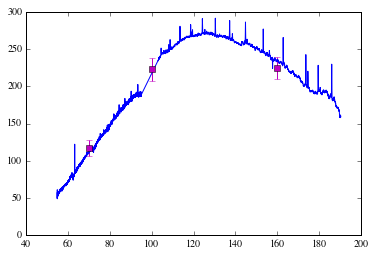

In [7]:
plt.plot(wl, flux)
plt.errorbar([70, 100, 160], phot['flux'], yerr=phot['uncertainty'], fmt='s', color='m', linestyle='None')

### Fit the weighted PACS spectrum

In [9]:
idl('.r /Users/yaolun/programs/line_fitting/gauss.pro')
idl('.r /Users/yaolun/programs/line_fitting/extract_pacs.pro')
idl.pro('extract_pacs', indir=outdir, filename='BHR71_pacs_weighted',
        outdir=outdir+'fitting/pacs/advanced_products/',
        plotdir=outdir+'fitting/pacs/advanced_products/plots/', noiselevel=3, ra=0, dec=0, global_noise=20,
        localbaseline=10, opt_width=1, continuum=1, flat=1, object='BHR71', double_gauss=1, fixed_width=1)

% Compiled module: GAUSS.
% Compiled module: EXTRACT_PACS.
% Compiled module: EXTRACT_PACS_LINESCAN.
---> Re-calculating the noise level...


<Container object of 3 artists>

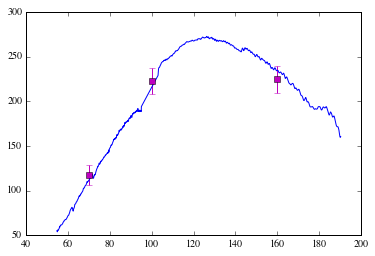

In [9]:
pacs_cont = ascii.read(outdir+'fitting/pacs/advanced_products/BHR71_pacs_weighted_continuum.txt')

plt.plot(pacs_cont['Wavelength(um)'], pacs_cont['Flux_Density(Jy)'])
plt.errorbar([70, 100, 160], phot['flux'], yerr=phot['uncertainty'], fmt='s', color='m', linestyle='None')

## SPIRE

### Call for HIPE

In [48]:
from subprocess import Popen, call
run = call(['hipe','/Users/programs/spectra_analysis/bhr71_sect_phot.py'])
run.communicate()

OSError: [Errno 2] No such file or directory

<Container object of 3 artists>

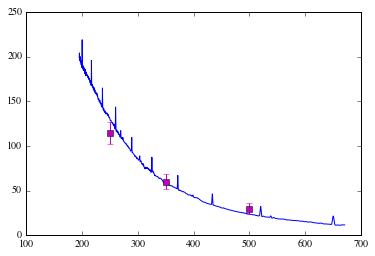

In [44]:
# read in the spectrum
spire_spec = ascii.read(outdir+'spire_sect.txt', data_start=4)
# convert it to the usual format
spire_wl = np.hstack((spire_spec['wave_segm1_0'][spire_spec['wave_segm1_0'] >= 310].data,
            spire_spec['wave_segm2_0'][(spire_spec['wave_segm2_0'] < 310) & (spire_spec['wave_segm2_0'] > 195)].data))
spire_flux = np.hstack((spire_spec['flux_segm1_0'][spire_spec['wave_segm1_0'] >= 310].data,
            spire_spec['flux_segm2_0'][(spire_spec['wave_segm2_0'] < 310) & (spire_spec['wave_segm2_0'] > 195)].data))

sorter = np.argsort(spire_wl)
spire_wl = spire_wl[sorter].data
spire_flux = spire_flux[sorter].data

# Write to file
foo = open(outdir+'BHR71_spire_corrected.txt','w')
foo.write('%s \t %s \n' % ('Wavelength(um)', 'Flux_Density(Jy)'))
for i in range(len(spire_wl)):
    foo.write('%f \t %f \n' % (spire_wl[i], spire_flux[i]))
foo.close()

# read in the photometry
spire_phot = ascii.read(outdir+'phot_sect.txt', data_start=4)

plt.plot(spire_wl, spire_flux)
plt.errorbar(spire_phot['wavelength(um)'], spire_phot['flux(Jy)'], yerr=spire_phot['uncertainty(Jy)'],
             fmt='s', color='m', linestyle='None')

In [50]:
idl('.r /Users/yaolun/programs/line_fitting/gauss.pro')
idl('.r /Users/yaolun/programs/line_fitting/extract_spire.pro')
idl.pro('extract_spire', indir=outdir, filename='BHR71_spire_corrected',
        outdir=outdir+'fitting/spire/advanced_products/',
        plotdir=outdir+'fitting/spire/advanced_products/plots/', noiselevel=3, ra=0, dec=0, global_noise=20,
        localbaseline=10, continuum=1, flat=1, object='BHR71', double_gauss=1, fx=1)

% Compiled module: GAUSS.
% Compiled module: EXTRACT_SPIRE.
---> Re-calculating the noise level...


<Container object of 3 artists>

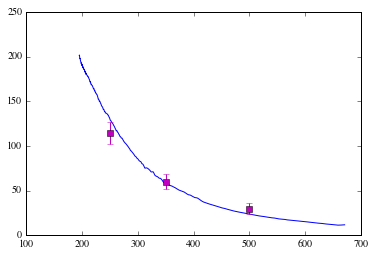

In [51]:
spire_cont = ascii.read(outdir+'fitting/spire/advanced_products/BHR71_spire_corrected_continuum.txt')

plt.plot(spire_cont['Wavelength(um)'], spire_cont['Flux_Density(Jy)'])
plt.errorbar(spire_phot['wavelength(um)'], spire_phot['flux(Jy)'], yerr=spire_phot['uncertainty(Jy)'],
             fmt='s', color='m', linestyle='None')

<Container object of 3 artists>

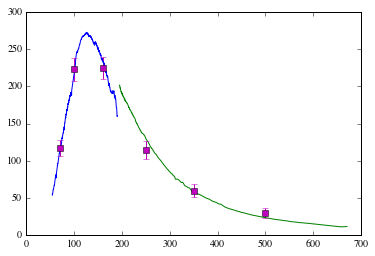

In [52]:
plt.plot(pacs_cont['Wavelength(um)'], pacs_cont['Flux_Density(Jy)'])
plt.errorbar([70, 100, 160], phot['flux'], yerr=phot['uncertainty'], fmt='s', color='m', linestyle='None')

plt.plot(spire_cont['Wavelength(um)'], spire_cont['Flux_Density(Jy)'])
plt.errorbar(spire_phot['wavelength(um)'], spire_phot['flux(Jy)'], yerr=spire_phot['uncertainty(Jy)'],
             fmt='s', color='m', linestyle='None')